# ShaderToy

In [6]:
import os
import numpy as np
import imageio
from IPython.display import Image, display

from wgpu_shadertoy import Shadertoy

def _mk_gif(shader, resolution, num_frames=100, step=1):
    from io import BytesIO
    from IPython.display import Video, display
    import imageio
    
    frames = [np.array(shader.snapshot(i)) for i in range(0, num_frames, step)]
    print(frames[0].shape)
    
    with BytesIO() as buffer:
        # Use get_writer instead of imwrite
        with imageio.get_writer(buffer, format='mp4', fps=5, quality=9, codec='h264') as writer:
            for frame in frames:
                writer.append_data(frame)
        video_bytes = buffer.getvalue()
    
    return display(Video(data=video_bytes, embed=True))

def render(cfp, resolution=(250, 250), stacktrace=False, gif=False):
    code = open(cfp).read() if os.path.exists(cfp) else cfp
    try:
        shader = Shadertoy(code, resolution=resolution, offscreen=gif)
        if gif: _mk_gif(shader, resolution)
        else: shader.show()
    except Exception as e:
        if stacktrace:
            raise e
        else:
            print("=== ERROR ===\n")
            print(e)

render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn shader_main( coord: vec2<f32>  ) -> vec4<f32>
{
    // normalized pixel coordinate (0-1)
    let uv: vec2<f32> = coord / i_resolution.xy;
    // x = red intensity (left to right)
    // y = green intensity (bottom to top)
    let intensity = abs(cos(i_time)); // 0-1
    let out = vec4<f32>(uv * intensity, 0.0, 1.0);
    return b2r(out);
}
""", gif=True, stacktrace=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (250, 250) to (256, 256) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


(250, 250, 4)


[libx264 @ 0x132705420] -qscale is ignored, -crf is recommended.


## Simple Square

Let's show a color. There seems to be some wonkiness when rendering with Jupyter (I think using Pillow?) it seems to render BGRA rather than RGBA. Tested this same code is rendered as BGRA when running as python using `glfw` renderer.

Anywho we've got a `b2r` function now.

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
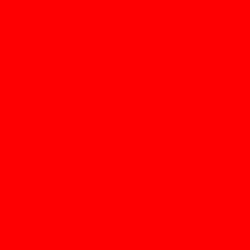

In [139]:
render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    return b2r(vec4<f32>(1.0, 0.0, 0.0, 1.0));
    
}
""")

## RG Color based on pixel position

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
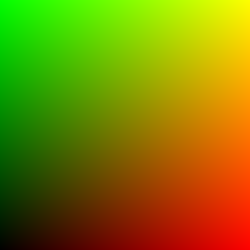

In [140]:
render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn shader_main( coord: vec2<f32>  ) -> vec4<f32>
{
    // normalized pixel coordinate (0-1)
    let uv: vec2<f32> = coord / i_resolution.xy;
    // x = red intensity (left to right)
    // y = green intensity (bottom to top)
    let out = vec4<f32>(uv, 0.0, 1.0);
    return b2r(out);
}
""")

## Modulate with time

First animated render! This modulates the intensity using `abs(cos)` (absoltute because -1 intensity is clamped to 0, so we'd rather it just be positive.

In [2]:
render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn shader_main( coord: vec2<f32>  ) -> vec4<f32>
{
    // normalized pixel coordinate (0-1)
    let uv: vec2<f32> = coord / i_resolution.xy;
    // x = red intensity (left to right)
    // y = green intensity (bottom to top)
    let intensity = abs(cos(i_time)); // 0-1
    let out = vec4<f32>(uv * intensity, 0.0, 1.0);
    return b2r(out);
}
""", gif=True, stacktrace=True)

(250, 250, 4)


ValueError: `ffmpeg` is not a registered plugin name.

## Square

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
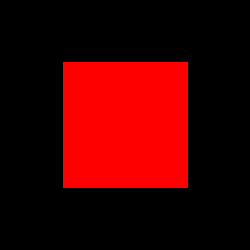

In [142]:
render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn square_indicator(coord: vec2<f32>, bound_x: vec2<f32>, bound_y: vec2<f32>) -> f32
{
    if (
        coord.x >= bound_x.x && coord.x <= bound_x.y    // inside x
        && coord.y >= bound_y.x && coord.y <= bound_y.y // inside y
    ) {
        return 1.0;
    }
    return 0.0;
}

fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv = coord / i_resolution.xy;
    let in_square: f32 = square_indicator(uv, vec2(0.25, 0.75), vec2(0.25, 0.75));
    if (in_square > 0.0) {
        return b2r(vec4(1.0, 0.0, 0.0, 1.0));
    }
    return b2r(vec4(0.0, 0.0, 0.0, 1.0));
    
}
""")

## Simple Circle

RFBOutputContext()

JupyterWgpuCanvas(css_height='250.0px', css_width='250.0px')
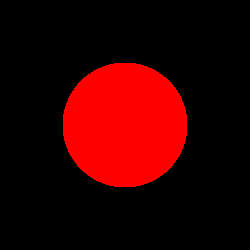

In [57]:
render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn circle_indicator(coord: vec2<f32>, radius: f32) -> f32
{
    // pythagoras
    if ((coord.x * coord.x + coord.y * coord.y) <= (radius * radius)) {
        return 1.0;
    }
    return 0.0;
}

fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv = coord / i_resolution.xy;
    // our circle is centered around 0, which since we start in the bottom left is 0,0
    // so if we want it centered we need to translate the center to 0,0
    let uv_translate = uv - vec2(0.5, 0.5);
    let in_square: f32 = circle_indicator(uv_translate, 0.25);
    if (in_square > 0.0) {
        return b2r(vec4(1.0, 0.0, 0.0, 1.0));
    }
    return b2r(vec4(0.0, 0.0, 0.0, 1.0));
}
""")

## Better Translate

We had an easy translate function in the previous function, but we're going to want to matrix combine our transformations in a bit so let's make a matmul version.

In [ ]:
render("""
fn b2r(bgra: vec4<f32>) -> vec4<f32>
{
    return bgra.bgra;
}

fn mk_translate(x: f32, y: f32) -> mat3x3<f32>
{
    return mat3x3<f32>(
        1.0, 0.0, x,
        0.0, 1.0, y,
        0.0, 0.0, 1.0,
    );
}

fn circle_indicator(coord: vec2<f32>, radius: f32) -> f32
{
    // pythagoras
    if ((coord.x * coord.x + coord.y * coord.y) <= (radius * radius)) {
        return 1.0;
    }
    return 0.0;
}

fn shader_main(coord: vec2<f32>) -> vec4<f32>
{
    let uv = coord / i_resolution.xy;
    // our circle is centered around 0, which since we start in the bottom left is 0,0
    // so if we want it centered we need to translate the center to 0,0
    let uv_translate = uv - vec2(0.5, 0.5);
    let in_square: f32 = circle_indicator(uv_translate, 0.25);
    if (in_square > 0.0) {
        return b2r(vec4(1.0, 0.0, 0.0, 1.0));
    }
    return b2r(vec4(0.0, 0.0, 0.0, 1.0));
}
""")